# 0061_practice_houseprices

After studying my previous notebook `#006_fastai_tabular_tricks`, this notebook is about my another practice of 'Houseprice' prediction.

- Kaggle competition: House Prices - Advanced Regression Techniques
    - Join the competition & download data: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data 

In [93]:
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
pd.options.display.max_rows = 20
pd.options.display.max_columns = 8
import warnings
warnings.filterwarnings('ignore')

In [94]:
path = Path("/Users/applewang/Desktop/Study_Materials_2023_2025/fastai_course/my-practice/house-prices-advanced-regression-techniques")
Path.BASE_PATH = path
path.ls()

(#4) [Path('test.csv'),Path('data_description.txt'),Path('train.csv'),Path('sample_submission.csv')]

In [95]:
train_df = pd.read_csv(path/'train.csv', low_memory=False)
df = train_df.copy()
df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,...,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,...,2008,WD,Normal,208500
1,2,20,RL,80.0,...,2007,WD,Normal,181500
2,3,60,RL,68.0,...,2008,WD,Normal,223500


## Process 

In [96]:
#check all features how many missing values - drop/fillna
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
#MoSold, YrSold change type to float64, otherwise will be labeled as categorical features
df['MoSold'] = df['MoSold'].astype('float64')
df['YrSold'] = df['YrSold'].astype('float64')

In [6]:
#Some features need to fill missing values
features = list(df.columns)
for i in features:
    if df[i].isnull().sum() >0:
        if df[i].dtype == 'object': df[i] = df[i].fillna('None') #features may have such conditions instead of missing records
        else: df[i] = df[i].fillna(df[i].median())

In [8]:
#process the y-target
dep_var = 'SalePrice'
df[dep_var] = np.log1p(df[dep_var])

In [9]:
splitter = RandomSplitter(0.3, seed=30)(df)
train_idx = splitter[0]
valid_idx = splitter[1]
splits = (list(train_idx),list(valid_idx))
cont, cat = cont_cat_split(df, dep_var=dep_var)

In [11]:
cont

['Id',
 'LotFrontage',
 'LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageYrBlt',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 'ScreenPorch',
 'MiscVal',
 'MoSold',
 'YrSold']

In [12]:
cat

['MSSubClass',
 'MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'GarageType',
 'GarageFinish',
 'GarageCars',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 '3SsnPorch',
 'PoolArea',
 'SaleType',
 'SaleCondition']

In [10]:
#procs=[FillMissing, Categorify, Normalize]
procs=[Categorify, Normalize]
to = TabularPandas(df, procs=procs, cat_names=cat, cont_names=cont, y_names=dep_var, splits=splits)

In [11]:
len(to.train), len(to.valid)

(1022, 438)

In [12]:
to.show(2)

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,3SsnPorch,PoolArea,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,Id,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,MiscVal,MoSold,YrSold,SalePrice
997,20,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,NWAmes,PosA,Norm,1Fam,1Story,6,6,Hip,CompShg,HdBoard,HdBoard,BrkFace,TA,TA,CBlock,TA,TA,No,Unf,Unf,GasA,TA,Y,SBrkr,0,0,2,0,2,1,TA,6,Typ,1,TA,Attchd,RFn,2,TA,TA,Y,0,0,None,None,None,WD,Normal,998.0,69.0,11717.0,1970.0,1970.0,571.0,0.0,0.0,1442.0,1442.0,1442.0,0.0,0.0,1442.0,1970.0,615.0,371.0,0.0,0.0,0.0,0.0,2.0,2009.0,12.128117
973,20,FV,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,Somerst,Norm,Norm,1Fam,1Story,7,5,Gable,CompShg,CemntBd,CmentBd,None,Gd,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,0,0,2,0,3,1,Gd,6,Typ,0,None,Attchd,Fin,2,TA,TA,Y,0,0,None,None,None,New,Partial,974.0,95.0,11639.0,2007.0,2008.0,0.0,0.0,0.0,1428.0,1428.0,1428.0,0.0,0.0,1428.0,2007.0,480.0,0.0,120.0,0.0,0.0,0.0,12.0,2008.0,12.111768


In [13]:
xs,y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

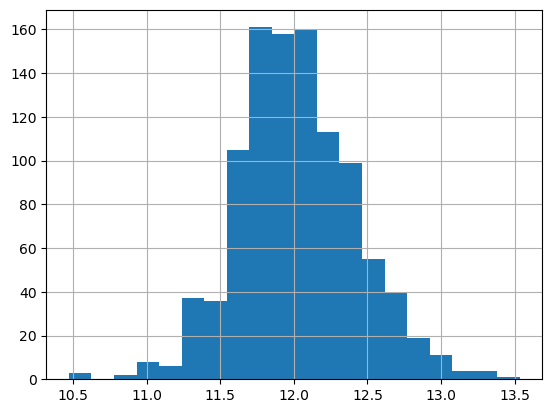

In [14]:
y.hist(bins=20);

In [15]:
np.expm1(y[:2]) #np.log1p逆操作，得出原始saleprice

997    185000.015625
973    182000.062500
Name: SalePrice, dtype: float32

## Model 1 - Decision Tree

In [16]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [17]:
m = DecisionTreeRegressor(max_leaf_nodes=5)
m.fit(xs,y)

DecisionTreeRegressor(max_leaf_nodes=5)

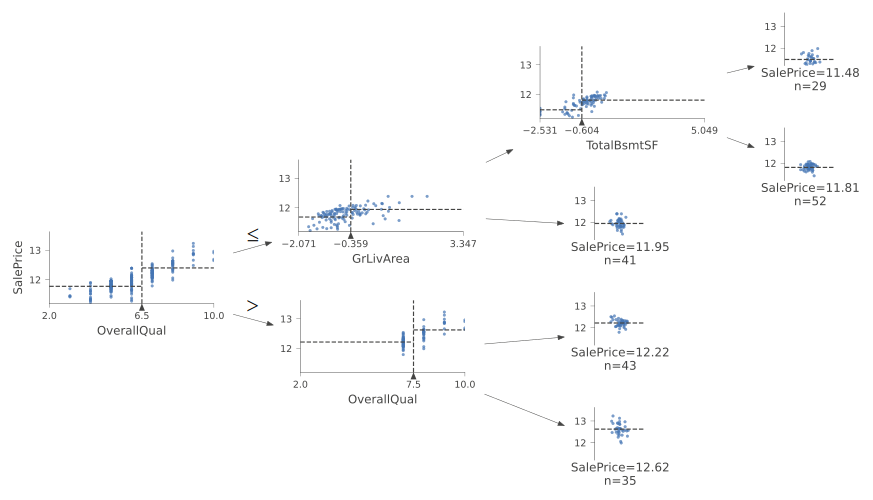

In [18]:
samp_idx = np.random.permutation(len(y))[:200]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

### Baseline rMSE

In [19]:
m = DecisionTreeRegressor(max_depth=3)
m.fit(xs, y)
m_rmse(m,xs,y), m_rmse(m, valid_xs, valid_y)

(0.209353, 0.228209)

In [20]:
m.get_n_leaves()

8

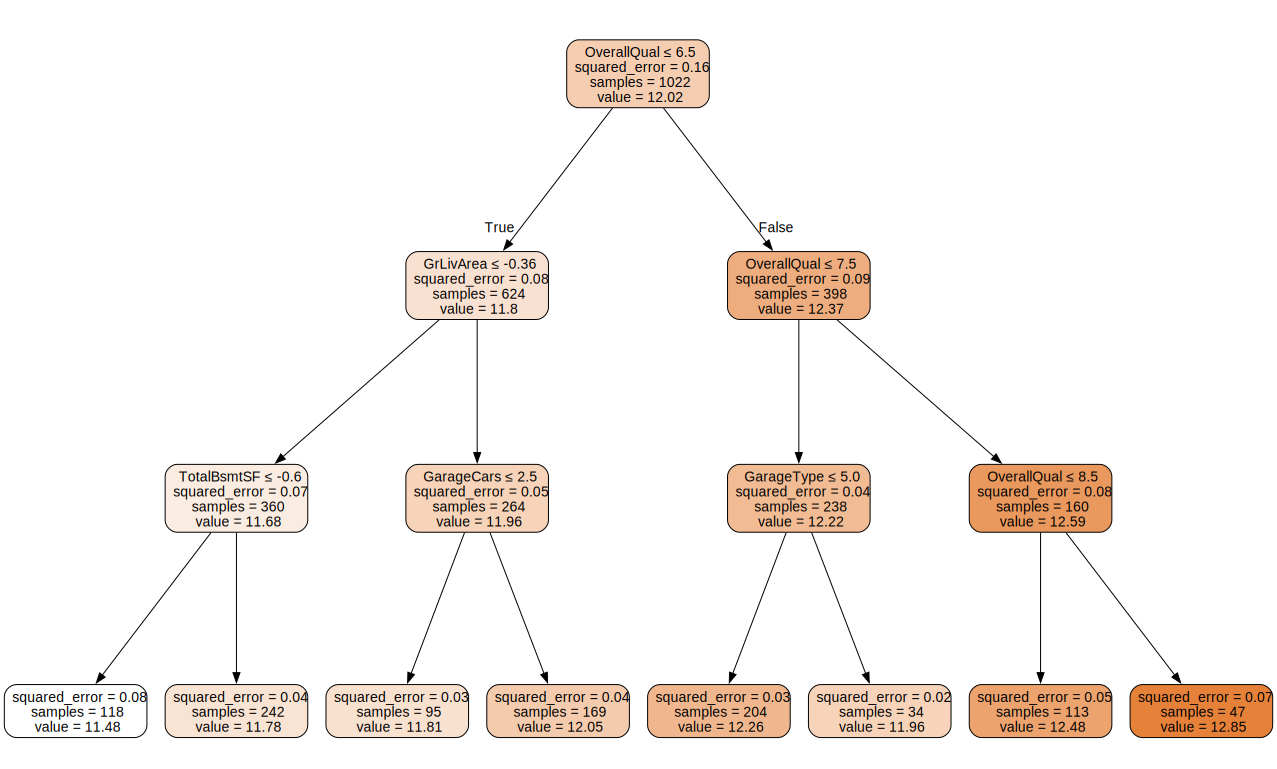

In [21]:
from sklearn.tree import export_graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=0, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))
draw_tree(m, xs, size=20,leaves_parallel=True, precision=2)

## Model 2 - Random forest

In [22]:
def rf(xs, y, n_estimators=50, max_samples=1000,max_depth=16, 
       min_samples_leaf=25, max_features=0.5, **kwargs):
    return RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1, 
                                 max_samples=max_samples, 
                                 min_samples_leaf=min_samples_leaf,max_depth=max_depth,
                                max_features=max_features,oob_score=True).fit(xs,y)

In [23]:
m2 = rf(xs, y)
m_rmse(m2, xs, y), m_rmse(m2, valid_xs, valid_y)

(0.151682, 0.165602)

In [24]:
r_mse(m2.oob_prediction_,y)

0.171491

Improving with a bit overfitting. -> Check the tree variances whether in wide range. (should not)

In [25]:
preds = np.stack([t.predict(valid_xs) for t in m2.estimators_])
preds.std(0)[:6]

array([0.1261692 , 0.15934388, 0.1351819 , 0.11430164, 0.19329701,
       0.05481956])

### Feature importance

In [26]:
def rf_feat_importance(df, m):
    return pd.DataFrame({'col':df.columns, 'imp': m.feature_importances_}).sort_values('imp', ascending=False)
rf_feat_importance(xs, m2)

,col,imp
14,OverallQual,0.408032
70,GrLivArea,0.140460
60,YearBuilt,0.110545
46,GarageCars,0.051022
66,TotalBsmtSF,0.039680
...,...,...
41,Functional,0.000000
17,RoofMatl,0.000000
16,RoofStyle,0.000000
38,KitchenAbvGr,0.000000


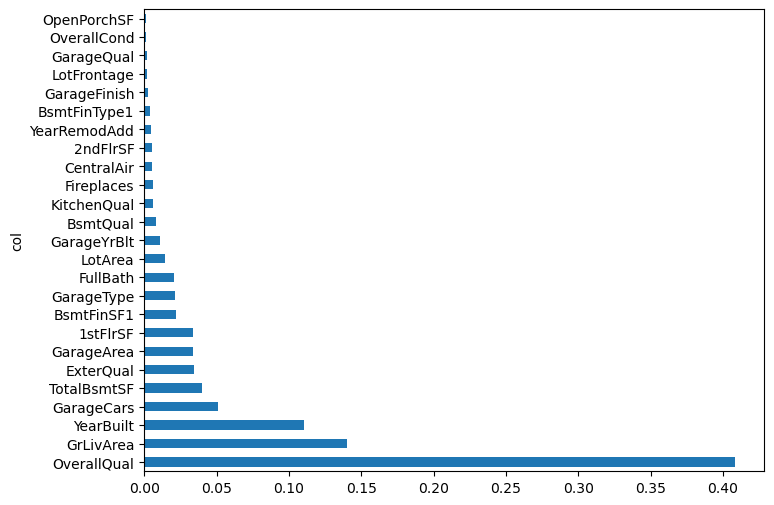

In [27]:
def plot_fi(fi):
    return fi.plot('col','imp','barh', figsize=(8,6), legend=False)
plot_fi(rf_feat_importance(xs, m2)[:25]);

#### Remove low importance features (worse)

In [28]:
fi = rf_feat_importance(xs, m2)
to_keep = fi[fi.imp>0.01]
len(to_keep)

13

In [29]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [30]:
m2_1 = rf(xs_imp,y)

In [31]:
m_rmse(m2_1, xs_imp,y), m_rmse(m2_1, valid_xs_imp, valid_y)

(0.403183, 0.390133)

After removing low important features, rMSE surprisely increases! Due to the training set is quite small, some features may have very low imp score but relating to other important features I guess. So removal of low importance features is not a good solution here.

### Find relationships of features

In [32]:
from scipy.cluster import hierarchy as hc

def cluster_columns(df, figsize=(8,6), font_size=8):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()

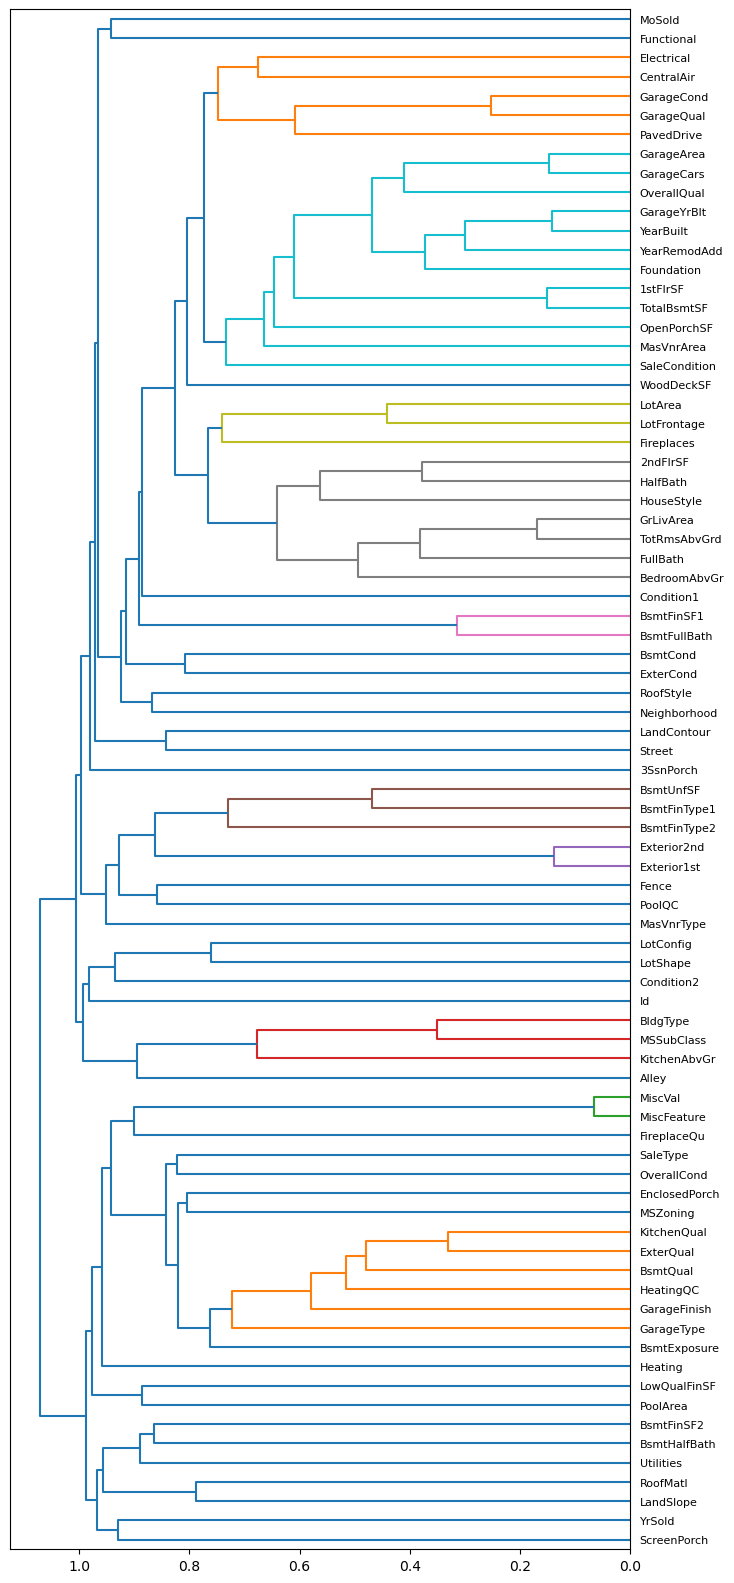

In [33]:
cluster_columns(xs, figsize=(8,20))

In [34]:
def get_oob(xs):
    m = rf(xs,y)
    return round(m.oob_score_,6)

In [35]:
get_oob(xs)

0.820149

In [51]:
{c: get_oob(xs.drop(c, axis=1)) for c in xs.columns}

{'MSSubClass': 0.816671,
 'MSZoning': 0.813455,
 'Street': 0.81888,
 'LotShape': 0.81744,
 'LandContour': 0.820252,
 'Utilities': 0.821844,
 'LotConfig': 0.821375,
 'LandSlope': 0.818227,
 'Neighborhood': 0.821829,
 'Condition1': 0.822295,
 'Condition2': 0.817621,
 'BldgType': 0.820953,
 'HouseStyle': 0.824426,
 'OverallQual': 0.804225,
 'OverallCond': 0.819827,
 'RoofStyle': 0.821052,
 'RoofMatl': 0.819011,
 'Exterior1st': 0.820851,
 'Exterior2nd': 0.823235,
 'ExterQual': 0.821927,
 'ExterCond': 0.818552,
 'Foundation': 0.826439,
 'BsmtQual': 0.828718,
 'BsmtCond': 0.819063,
 'BsmtExposure': 0.824165,
 'BsmtFinType1': 0.821952,
 'BsmtFinType2': 0.820139,
 'Heating': 0.822604,
 'HeatingQC': 0.818669,
 'CentralAir': 0.818888,
 'Electrical': 0.823042,
 'BsmtFullBath': 0.822197,
 'BsmtHalfBath': 0.822141,
 'FullBath': 0.820608,
 'HalfBath': 0.825748,
 'BedroomAbvGr': 0.819318,
 'KitchenAbvGr': 0.817542,
 'KitchenQual': 0.82092,
 'TotRmsAbvGrd': 0.821208,
 'Functional': 0.820386,
 'Firepla

In [36]:
to_drop=['Id', 'Exterior1st', 'BsmtFinType1', 'CentralAir','Fireplaces','GarageYrBlt']
xs_imp = xs.drop(to_drop, axis=1)
get_oob(xs_imp)

0.82125

In [37]:
valid_xs_imp=valid_xs.drop(to_drop, axis=1)
m2_2 = rf(xs_imp,y)
m_rmse(m2_2,xs_imp,y), m_rmse(m2_2, valid_xs_imp, valid_y)

(0.150993, 0.167264)

A bit worse as well...😅 try less to drop?

In [38]:
to_drop=['Id']
xs_imp = xs.drop(to_drop, axis=1)
get_oob(xs_imp)

0.82155

In [39]:
valid_xs_imp=valid_xs.drop(to_drop, axis=1)
m2_3 = rf(xs_imp,y)
m_rmse(m2_3,xs_imp,y), m_rmse(m2_3, valid_xs_imp, valid_y)

(0.151297, 0.166289)

A little better. It shows that those features are quite useful with specific information instead of getting rid of. 

How about the performance of boosting models, or Neural networks?

## Model 3 - Boosting

### sklearn - GradientBoostingRegressor

In [40]:
from sklearn.ensemble import GradientBoostingRegressor

In [41]:
m3 = GradientBoostingRegressor().fit(xs_imp,y)

In [42]:
m_rmse(m3, xs_imp, y), m_rmse(m3, valid_xs_imp, valid_y)

(0.076222, 0.125253)

Quite better than all models above 👍👍👍

### Xgboost

In [43]:
import xgboost

In [44]:
m3_1 = xgboost.XGBRegressor(n_estimators=300, max_depth=2, learning_rate=0.1).fit(xs_imp,y)

In [45]:
m_rmse(m3_1, xs_imp, y), m_rmse(m3_1, valid_xs_imp, valid_y)

(0.079792, 0.121902)

It improves a lot comparing with RF.

In [46]:
m3_2 = xgboost.XGBRFRegressor().fit(xs_imp,y)

In [47]:
m_rmse(m3_2, xs_imp, y), m_rmse(m3_2, valid_xs_imp, valid_y)

(0.095416, 0.148934)

XGBRF is a little worse than XGB here. This also shows that the features with low importance but they are non-linear with inter-relationships.

### LightGBM

In [48]:
import lightgbm

In [49]:
m3_3 = lightgbm.LGBMRegressor(max_depth=2, n_estimators=300).fit(xs_imp,y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3045
[LightGBM] [Info] Number of data points in the train set: 1022, number of used features: 71
[LightGBM] [Info] Start training from score 12.022300
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [50]:
m_rmse(m3_3, xs_imp, y), m_rmse(m3_3, valid_xs_imp, valid_y)

(0.086641, 0.13028)

### Lasso regression

In [51]:
from sklearn.linear_model import LassoCV

In [52]:
m3_4 = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(xs_imp,y)

In [53]:
m_rmse(m3_4, xs_imp, y), m_rmse(m3_4, valid_xs_imp, valid_y)

(0.124976, 0.176014)

So far, **XGB is the best model** (lowest rMSE of train 0.079 /valid 0.119) with a bit overfitting. 

## Nerual networks

In [68]:
y.min(), y.max()

(10.471978, 13.534474)

In [69]:
df_nn = df.copy()
procs_nn = [FillMissing, Categorify, Normalize]
cont_nn, cat_nn = cont_cat_split(df_nn, dep_var=dep_var)
to_nn = TabularPandas(df_nn, procs_nn, cat_nn, cont_nn, y_names=dep_var, splits=splits)

In [70]:
df_nn.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,...,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,...,2008.0,WD,Normal,12.247699
1,2,20,RL,80.0,...,2007.0,WD,Normal,12.109016


In [71]:
dls = to_nn.dataloaders(bs=32)

In [72]:
learn = tabular_learner(dls, y_range=(10, 14), layers=[300,100], n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.0010000000474974513)

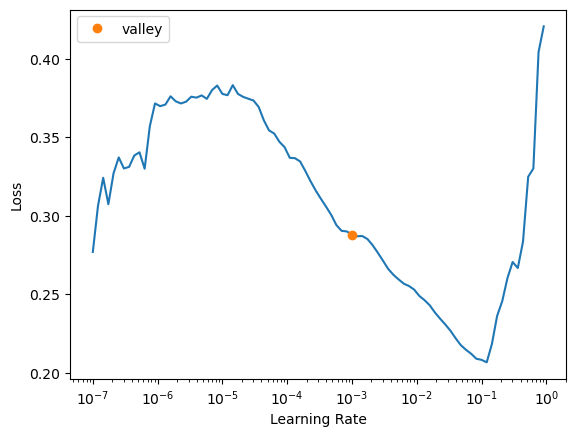

In [73]:
learn.lr_find()

In [74]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,time
0,0.190705,0.087469,00:00
1,0.128669,0.062832,00:00
2,0.089258,0.060413,00:00
3,0.063514,0.044402,00:00
4,0.048214,0.058722,00:00


In [75]:
preds, targs = learn.get_preds()
r_mse(preds, targs)

0.242325

## Ensemble XGBoost & NN

In [76]:
pred_xgboost = m3_1.predict(valid_xs_imp)

In [77]:
pred_nn = to_np(preds.squeeze())

In [78]:
pred_en = (0.8*pred_xgboost + 0.2*pred_nn)

In [79]:
r_mse(pred_en, valid_y)

0.126053

## Submission - Test data

In [80]:
test_df = pd.read_csv(path/'test.csv', low_memory=False)
tdf = test_df.copy()
tdf.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,...,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,...,6,2010,WD,Normal
1,1462,20,RL,81.0,...,6,2010,WD,Normal


### Process - Test data

In [81]:
tdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [82]:
tdf['MoSold'] = tdf['MoSold'].astype('float64')
tdf['YrSold'] = tdf['YrSold'].astype('float64')
#to_drop = ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence',  'MiscFeature']
#tdf = tdf.drop(to_drop, axis=1)
tfeatures = list(tdf.columns)
for i in tfeatures:
    if tdf[i].isnull().sum() >0:
        if tdf[i].dtype == 'object': tdf[i] = tdf[i].fillna('None') #fill modes may inaccurate
        else: tdf[i] = tdf[i].fillna(df[i].median()) #use train's median

In [105]:
#cont_t, cat_t = cont_cat_split(tdf, dep_var=None)

In [83]:
tto = to.new(tdf)

In [84]:
tto.process()
txs = tto.items
txs = txs.drop(['Id'], axis=1)
txs = txs[xs_imp.columns]
txs.head(2)

,MSSubClass,MSZoning,Street,Alley,...,ScreenPorch,MiscVal,MoSold,YrSold
0,1,3,2,2,...,1.847983,-0.082599,-0.152881,1.614682
1,1,4,2,2,...,-0.273845,24.262283,-0.152881,1.614682


### Predictions

In [85]:
preds_xgb = m3_1.predict(txs)

In [86]:
tdl = learn.dls.test_dl(tdf)

p,_ = learn.get_preds(dl=tdl)
preds_nn = to_np(p.squeeze())

In [87]:
len(preds_nn)

1459

In [88]:
preds_log = (0.8*preds_xgb + 0.2*preds_nn)
preds_final = np.expm1(preds_log)
preds_final

array([125539.914, 110971.72 , 186819.27 , ..., 171021.44 , 109842.04 ,
       216741.78 ], dtype=float32)

In [89]:
preds_df = pd.DataFrame(preds_final, columns=['SalePrice'])

In [90]:
preds_df['Id'] = test_df['Id']

In [91]:
submission = preds_df[['Id', 'SalePrice']]
submission

,Id,SalePrice
0,1461,125539.914062
1,1462,110971.718750
2,1463,186819.265625
3,1464,188380.953125
4,1465,189339.687500
...,...,...
1454,2915,81553.109375
1455,2916,81302.273438
1456,2917,171021.437500
1457,2918,109842.039062


In [92]:
submission.to_csv('houseprice_sub1.csv', index=False)

'houseprice_sub1.csv' - kaggle 0.14222

In [ ]:
from fastkaggle import *

push_notebook('apple9855wang', 'House-Price-Predictions-practice-1',
             title='House-Price-Predictions-practice-1',
             file='0061_practice_houseprices.ipynb',
             competition='house-prices-advanced-regression-techniques'
             )